# Loading the data

In [1]:
import pandas as pd
import ast


In [2]:
# First you need to download the data from https://www.kaggle.com/datasets/kakarlaramcharan/tmdb-data-0920
# Unzip it and place it in the `input` directory

In [3]:
# Import data from input/movie_data_tmbd.csv, use engine=python, because the file is too big for the default engine
df = pd.read_csv('input/movie_data_tmbd.csv', sep='|', engine='python')

In [4]:
# Print info about the data
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119938 entries, 0 to 119937
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   adult                  119938 non-null  object 
 1   backdrop_path          67084 non-null   object 
 2   belongs_to_collection  9488 non-null    object 
 3   budget                 119394 non-null  object 
 4   genres                 119394 non-null  object 
 5   homepage               20134 non-null   object 
 6   id                     119394 non-null  float64
 7   imdb_id                114477 non-null  object 
 8   original_language      119394 non-null  object 
 9   original_title         119394 non-null  object 
 10  overview               116539 non-null  object 
 11  popularity             119073 non-null  object 
 12  poster_path            119073 non-null  object 
 13  production_companies   119073 non-null  object 
 14  production_countries   119073 non-nu

In [5]:
# How many titles are there in the dataset?
print(df.shape[0])
# How many titles have no less than 50 votes?
print(df[df['vote_count'] >= 50].shape[0])

119938
17426


In [6]:
# Drop rows with less than 10 votes
df = df[df['vote_count'] >= 40]

In [7]:
print(df['vote_average'].map(lambda x: int(x)).value_counts())

vote_average
6    8204
7    5102
5    4642
4    1111
8     520
3     177
2      33
9       6
1       3
Name: count, dtype: int64


Axes(0.125,0.11;0.775x0.77)


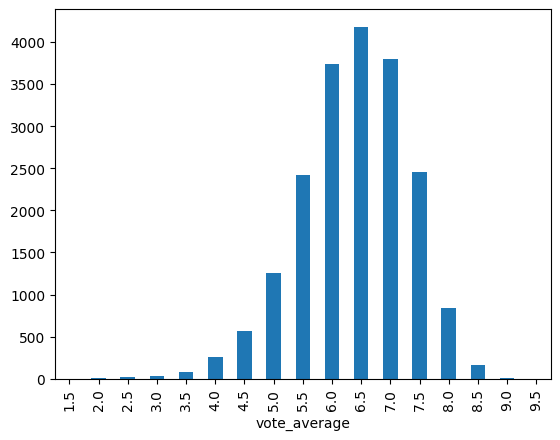

In [8]:
# Map 'vote_average' to nearest 0.5
print(((df['vote_average'] * 2).round() / 2).value_counts().sort_index().plot(kind='bar'))

# Data preprocessing

In [9]:
# Print info about the data
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 19798 entries, 2 to 119913
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  19798 non-null  object 
 1   backdrop_path          18153 non-null  object 
 2   belongs_to_collection  3671 non-null   object 
 3   budget                 19798 non-null  object 
 4   genres                 19798 non-null  object 
 5   homepage               5413 non-null   object 
 6   id                     19798 non-null  float64
 7   imdb_id                19790 non-null  object 
 8   original_language      19798 non-null  object 
 9   original_title         19798 non-null  object 
 10  overview               19719 non-null  object 
 11  popularity             19798 non-null  object 
 12  poster_path            19798 non-null  object 
 13  production_companies   19798 non-null  object 
 14  production_countries   19798 non-null  object 
 15  releas

In [10]:
# Find missing values in `tagline`, `overview`
print(df['tagline'].isna().sum())
print(df['overview'].isna().sum())

6941
79


In [11]:
# Fill missing values
df['tagline'] = df['tagline'].fillna('Unknown')
df['overview'] = df['overview'].fillna('Unknown')

In [12]:
# Drop rows with mising release date
df = df.dropna(subset=['release_date'])

# Convert 'release_date' to datetime and extract year, month, day
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_year'] = df['release_date'].dt.year
df['release_month'] = df['release_date'].dt.month
df['release_day'] = df['release_date'].dt.day

In [13]:
# Handle boolean columns by converting them to integers
# Map `False`/True` to 0/1
df['adult'] = df['adult'].replace({'True': 1, 'False': 0})
df['video'] = df['video'].astype(int)

In [14]:
# Define a helper function to extract names from nested dictionaries in a column
def extract_names(column):
    return column.apply(lambda x: ','.join([d.get('name') for d in ast.literal_eval(x)] if pd.notnull(x) and x != '[]' else []))

# Extract relevant data from nested dictionaries
df['genres'] = extract_names(df['genres'])
df['production_companies'] = extract_names(df['production_companies'])
df['production_countries'] = extract_names(df['production_countries'])
df['cast'] = extract_names(df['cast'])
df['directors'] = extract_names(df['directors'])
df['spoken_languages'] = extract_names(df['spoken_languages'])

In [15]:
# Drop unnecessary columns
df = df.drop(['belongs_to_collection', 'backdrop_path', 'poster_path', 'imdb_id', 'original_title', 'title', 'id', 'homepage', 'release_date'], axis=1)

In [16]:
print(df.head())

    adult budget         genres original_language  \
2       0      0  Drama,Western                en   
3       0      0    Documentary                fr   
7       0      0        Western                en   
18      0      0        History                it   
24      0      0          Drama                en   

                                             overview popularity  \
2   A fiercely independent cowboy arranges to have...      8.262   
3   Documents the lives of infamous fakers Elmyr d...       7.83   
7   Character study of a Doctor who saves a local ...      7.869   
18  While on holiday in Rhodes, Athenian war hero ...      9.668   
24  In early 1960s London, barrister Melville Farr...      5.896   

                                 production_companies  \
2                                    Joel Productions   
3                                    SACI,Janus Films   
7                        Baroda,Warner Bros. Pictures   
18  Produzioni Atlas Consorziate,Procusa,Com

Axes(0.125,0.11;0.775x0.77)


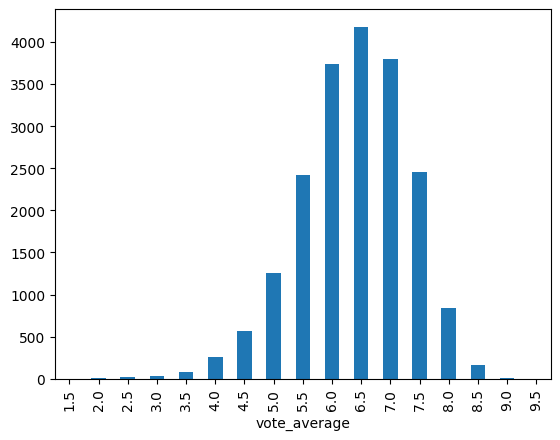

In [17]:
# Map 'vote_average' to nearest 0.5
df['vote_average'] = ((df['vote_average'] * 2).round() / 2)
print(df['vote_average'].value_counts().sort_index().plot(kind='bar'))

In [18]:
#Group vote_average into categories:
# 0.0-5.0 -> bad
# 5.5-6.0 -> mediocre
# 6.5-7.0 -> good
# 7.5-9.9 -> great

# Define the bins and labels
bins = [0.0, 5.0, 6.0, 7.0, 9.9]
labels = ['bad', 'mediocre', 'good', 'great']

# Group vote_average into categories
df['category'] = pd.cut(df['vote_average'], bins=bins, labels=labels, right=True)

# Display the DataFrame
print(df['category'].value_counts())
n = df['category'].value_counts().min()
print(n)

category
good        7979
mediocre    6154
great       3468
bad         2196
Name: count, dtype: int64
2196


In [19]:
# Take the same number of samples from each category
# Group by 'category', sort by 'vote_count' within each group, and take the top n
df_top_votes = df.groupby('category', group_keys=False).apply(lambda x: x.nlargest(n, 'vote_count'))

# If you want to reset the index after, you can use:
df = df_top_votes.reset_index(drop=True)

C:\Users\Azevedo\AppData\Local\Temp\ipykernel_22896\218362143.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_top_votes = df.groupby('category', group_keys=False).apply(lambda x: x.nlargest(n, 'vote_count'))


In [20]:
print(df['category'].value_counts())
print(df.shape)

category
bad         2196
mediocre    2196
good        2196
great       2196
Name: count, dtype: int64
(8784, 22)


# Save data to file

In [21]:
# Save the cleaned data to input/movie_data_tmbd_cleaned.csv
df.to_csv('input/movie_data_tmbd_cleaned.csv', sep='|', index=False)